# Libraries and Data

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
import skopt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)
sample = pd.read_csv("../data/sample_submission.csv", low_memory = False)

In [3]:
train.shape, test.shape

((37439, 40), (10000, 39))

In [4]:
train.columns, test.columns

(Index(['Id', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
        'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region', 'Elementary School', 'Elementary School Score',
        'Elementary School Distance', 'Middle School', 'Middle School Score',
        'Middle School Distance', 'High School', 'High School Score',
        'High School Distance', 'Flooring', 'Heating features',
        'Cooling features', 'Appliances included', 'Laundry features',
        'Parking features', 'Tax assessed value', 'Annual tax amount',
        'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
        'Zip', 'State'],
       dtype='object'),
 Index(['Id', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
        'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region',

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37439 entries, 0 to 37438
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           37439 non-null  int64  
 1   Sold Price                   37439 non-null  int64  
 2   Summary                      37176 non-null  object 
 3   Type                         37439 non-null  object 
 4   Year built                   36686 non-null  float64
 5   Heating                      32481 non-null  object 
 6   Cooling                      29109 non-null  object 
 7   Parking                      36720 non-null  object 
 8   Lot                          26041 non-null  float64
 9   Bedrooms                     35235 non-null  object 
 10  Bathrooms                    34786 non-null  float64
 11  Full bathrooms               31696 non-null  float64
 12  Total interior livable area  35443 non-null  float64
 13  Total spaces    

# Data Pre-Processing

<AxesSubplot:xlabel='Garage spaces', ylabel='Count'>

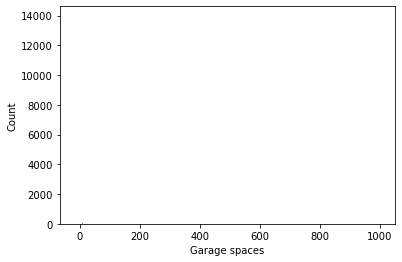

In [6]:
#sns.histplot(np.log(train["Sold Price"]))
sns.histplot(train["Garage spaces"])
#train["Year built"].unique()


<AxesSubplot:>

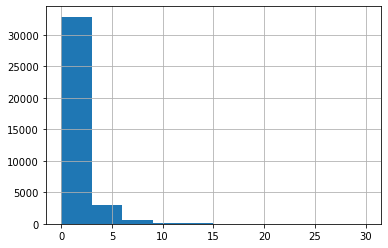

In [7]:
np.abs(np.minimum(train["Total spaces"], 30)).hist()

In [8]:
np.abs?

## Exploring Heating Variable

In [9]:
asdf = train["Heating"].value_counts()
asdf

Central                                            7280
Central Forced Air                                 4695
Central Forced Air - Gas                           3041
Forced Air                                         1977
Wall Furnace                                       1535
                                                   ... 
Stove - Wood, Other                                   1
Radiant, Daiken Mini Splits                           1
Solar, Central Forced Air - Gas, Radiant Floors       1
Propane, Electric, Wall Furnace, Wood Stove           1
Natural Gas, Electric                                 1
Name: Heating, Length: 1536, dtype: int64

In [10]:
train["Heating"].str.lower().value_counts()

central                                     7281
central forced air                          4695
central forced air - gas                    3041
forced air                                  2885
wall furnace                                1535
                                            ... 
forced air, other, radiant, gas, other         1
electric, see remarks, forced air              1
propane, zoned, forced air                     1
forced air, heating - 2+ zones, electric       1
natural gas, electric                          1
Name: Heating, Length: 1525, dtype: int64

In [11]:
heat_types = train["Heating"].str.lower().str.split(",").explode().str.strip().unique()
heat_types
# h1 = central, forced air, forced, furnace
# h2 = radiant, heat pump, baseboard, steam, zone
# h3 = wood, stove, fireplace, fire, coal, pellet
# h4 = solar, geothermal

array(['central', 'forced air', 'central forced air', 'other',
       'central forced air - gas', 'radiant', 'wall furnace', nan,
       'electric', 'radiant floors', 'individual room controls', 'gas',
       'heating - 2+ zones', 'zoned', 'none', 'wall', 'baseboard',
       'steam', 'combination', 'forced air - gas', 'propane / butane',
       'propane', 'woodstove', 'natural gas', 'fireplace(s)',
       'floor furnace', 'fireplace', 'stove - wood', 'gravity',
       'heat pump', 'stove', 'energy star qualified equipment',
       'see remarks', 'wood stove', 'solar', 'oil', 'pellet stove',
       'fireplace insert', 'gas pac', 'propane heat', 'cfag',
       'forced air - elec', 'wood / pellet', 'passive solar', 'wood',
       'zoned - gas', 'no heating', 'hot water', 'wood burn. stove',
       'electric furnace', 'kerosene/oil', 'stove - pellet', 'space',
       'stove - propane', 'solar and gas', 'mini split', 'stove propane',
       'common', 'high efficiency', 'stove heater', 'forc

In [12]:
train["Full bathrooms"].isna().any()

True

In [13]:
np.min(train["Year built"])

0.0

In [14]:
train.median()["Sold Price"]

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


1042000.0

Impute missing values for certain numeric variables

In [15]:
train_medians = train.median()

def preprocess_data(df, meds):
    df["Total interior livable area"] = df["Total interior livable area"].fillna(meds["Total interior livable area"])
    
    df["Bathrooms"] = df["Bathrooms"].fillna(meds["Bathrooms"])
    
    df["Total spaces"] = df["Total spaces"].fillna(meds["Total spaces"])
    df["Total spaces"] = np.abs(np.minimum(df["Total spaces"], 30))
    
    df["High School Score"] = df["High School Score"].fillna(meds["High School Score"])
    
    df["Year built"] = df["Year built"].fillna(meds["Year built"])
    df["Year built"] = np.maximum(df["Year built"], 1870)
    df["Year built"] = np.minimum(df["Year built"], 2022)
    
    df["state_ind"] = df["State"] == "CA"
    
    df["Garage spaces"] = df["Garage spaces"].fillna(meds["Garage spaces"])
    df["Garage spaces"] = np.maximum(df["Garage spaces"], 0)
    df["Garage spaces"] = np.minimum(df["Garage spaces"], 20)
    
    df["Elementary School Score"] = df["Elementary School Score"].fillna(meds["Elementary School Score"])
    
    df["Full bathrooms"] = df["Full bathrooms"].fillna(meds["Full bathrooms"])
  
    df["h1"] = (train["Heating"].str.lower().str.contains("central") | 
                train["Heating"].str.lower().str.contains("forced")  |
                train["Heating"].str.lower().str.contains("furnace") |
                train["Heating"].str.lower().str.contains("air"))
    df["h2"] = (train["Heating"].str.lower().str.contains("radiant") | 
                train["Heating"].str.lower().str.contains("heat pump")  |
                train["Heating"].str.lower().str.contains("steam") |
                train["Heating"].str.lower().str.contains("baseboard") |
                train["Heating"].str.lower().str.contains("zone"))
    df["h3"] = (train["Heating"].str.lower().str.contains("wood") | 
                train["Heating"].str.lower().str.contains("stove")  |
                train["Heating"].str.lower().str.contains("fire") |
                train["Heating"].str.lower().str.contains("coal") |
                train["Heating"].str.lower().str.contains("pellet"))
    df["h4"] = (train["Heating"].str.lower().str.contains("solar") | 
                train["Heating"].str.lower().str.contains("geothermal"))
 
    return df

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [16]:
train = preprocess_data(train, train_medians)

Transform the target by logging it since it's got a long right tail

In [17]:
y = np.log(train["Sold Price"])

In [74]:
pred_vars = ["Listed Price", "Total interior livable area", "Bathrooms", 
             "Year built", "High School Score", "Garage spaces", "state_ind", 
            "Elementary School Score", "Full bathrooms", "h1", #"h2", "h3", "h4",
            "Total spaces"]

X = train[pred_vars]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=56)

# Models

In [98]:
params = {"n_estimators":50,
          "learning_rate":0.15,
          "max_depth":5,
          "random_state":56,
          "subsample":1,
          'max_features':None, # None or sqrt
          "loss":'squared_error'}

In [99]:
model = GradientBoostingRegressor().set_params(**params)

In [100]:
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=5, n_estimators=50,
                          random_state=56, subsample=1)

In [101]:
model.score(X_test, y_test)

0.9297403649229657

In [97]:
model.score?

<AxesSubplot:>

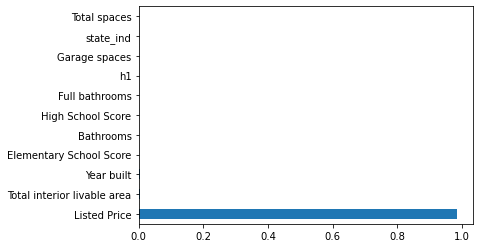

In [102]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

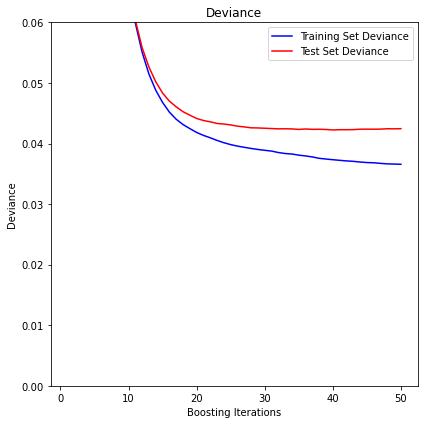

In [103]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.ylim(0, 0.06)
fig.tight_layout()
plt.show()

Train final model with all the data

# Hyperparameter Optimization

In [130]:
BayesSearchCV?

In [135]:
opt = BayesSearchCV(
    GradientBoostingRegressor(random_state = 56,loss = 'squared_error'),
    {
        'n_estimators': (50, 1000),
        'learning_rate': (1e-5, .9, 'log-uniform'),
        'max_depth': (2, 6),  # integer valued parameter
        'subsample': (0.05, 1.0, 'uniform')
    },
    n_iter = 3,
    cv = 3,
    verbose = 1
)

In [136]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  11.3s
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  12.2s
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  12.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.00016189871380357706, max_depth=6, n_estimators=

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=56),
              n_iter=3,
              search_spaces={'learning_rate': (1e-05, 0.9, 'log-uniform'),
                             'max_depth': (2, 6), 'n_estimators': (50, 1000),
                             'subsample': (0.05, 1.0, 'uniform')},
              verbose=2)

In [35]:
opt.score(X_test, y_test)

# 0.930401 with no subsampling
# 0.929161025403613 with subsampling, 50 iterations


0.9301608507840881

In [36]:
opt.best_estimator_.max_depth, opt.best_estimator_.learning_rate, opt.best_estimator_.n_estimators, opt.best_estimator_.subsample

# (4, 0.019076781177538346, 500, 1.0) with no subsampling
# (5, 0.011876032175591269, 376, 0.44775503528274996) with subsampling (50 iterations)


(4, 0.012474997352881075, 614, 0.3871953641896431)

In [38]:
params["max_depth"] = opt.best_estimator_.max_depth
params["learning_rate"] = opt.best_estimator_.learning_rate
params["n_estimators"] = opt.best_estimator_.n_estimators
params["subsample"] = opt.best_estimator_.subsample

In [99]:
GradientBoostingRegressor?

In [67]:
model = GradientBoostingRegressor().set_params(**params).fit(X, y)

# Make Predictions

Do the same pre-processing on the test data that we do on the train data

In [69]:
test_medians = test.median()

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [72]:
test = preprocess_data(test, test_medians)
test["Sold Price"] = np.exp(model.predict(test[pred_vars]))

In [73]:
test[["Id", "Sold Price"]].to_csv("../submission.csv", index = False)